In [6]:
import yaml
import torch
import numpy as np
from torch_geometric.loader import DataLoader
import pandas as pd
import random
from model import ILBERT,ILBERT_T,ILBERT_T_P
from dataset import SMILES_dataset
from ILtokenizer import SMILES_Atomwise_Tokenizer
from tqdm import tqdm

def predict_csv(data_file,task):
    config_path = "config_final.yaml"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_paths = [
        f'model_weight/{task}/fold_1_best_model.pth',
        f'model_weight/{task}/fold_2_best_model.pth',
        f'model_weight/{task}/fold_3_best_model.pth',
        f'model_weight/{task}/fold_4_best_model.pth',
        f'model_weight/{task}/fold_5_best_model.pth',
        f'model_weight/{task}/fold_6_best_model.pth',
        f'model_weight/{task}/fold_7_best_model.pth',
        f'model_weight/{task}/fold_8_best_model.pth',
        f'model_weight/{task}/fold_9_best_model.pth',
        f'model_weight/{task}/fold_10_best_model.pth'
        ]
    
    if task =='Melting point':
        target='IL'
        means, stds = 363.0857, 75.0207         # tensor(363.0857) tensor(75.0207) torch.Size([26730, 1, 1])

    elif task =='Glass transition temperature':
        target='IL'
        means, stds = 215.6339, 29.5529          # tensor(215.6339) tensor(29.5529) torch.Size([7930, 1, 1])

    elif task =='Thermal decomposition temperature':
        target='IL'
        means, stds = 522.9653, 76.1426         # tensor(522.9653) tensor(76.1426) torch.Size([27790, 1, 1])

    elif task =='IPC-81':
        target='IL'
        means, stds = 3.1156, 1.0641            # tensor(3.1156) tensor(1.0641) torch.Size([3550, 1, 1])

    elif task =='Electrical conductivity':
        target='lnEC'
        means, stds = -1.0393, 1.5858            # tensor(-1.0393) tensor(1.5858) torch.Size([2168, 1, 1])

    elif task =='Thermal conductivity':
        target='TC/W m-1 K-1'
        means, stds = 0.1507, 0.0254            # tensor(0.1507) tensor(0.0254) torch.Size([606, 1, 1])

    elif task =='Density':
        target='d_kg m-3'
        means, stds = 1218.4255, 165.7802        # tensor(1218.4255) tensor(165.7802) torch.Size([39830, 1, 1])

    elif task =='Surface tension':
        target='s_mNm'
        means, stds = 38.2560, 9.0138            # tensor(38.2560) tensor(9.0138) torch.Size([5990, 1, 1])

    elif task =='Refractive index':
        target='R'
        means, stds = 1.4676, 0.0407            # tensor(1.4676) tensor(0.0407) torch.Size([3596, 1, 1])

    elif task =='Viscosity':
        target='ln(n_mPas)'
        means, stds = 4.1952, 1.6220            # tensor(4.1952) tensor(1.6220) torch.Size([15368, 1, 1])

    elif task =='CO2':
        target='ln(x_CO2)'
        means, stds = -1.5511, 1.2642            # tensor(0.3349) tensor(0.2362) torch.Size([10116, 1, 1])/ tensor(-1.5511) tensor(1.2642) torch.Size([10116, 1, 1])


    elif task =='Heat capacity':
        target='lnhc'
        means, stds = 6.2754, 0.3585            # tensor(6.2754) tensor(0.3585) torch.Size([11539, 1, 1])

    outputs = []

    test_dataset = SMILES_dataset(df=pd.read_csv(data_file), tokenizer=SMILES_Atomwise_Tokenizer('D:/QYX/SmilesPE-master/merged_vocab.txt'), target=target)

    for model_path in tqdm(model_paths, desc="Processing Models"):
    

        config = yaml.load(open(config_path, "r", encoding="utf-8"), Loader=yaml.FullLoader)

        if task in ['Melting point', 'Glass transition temperature', 'Thermal decomposition temperature', 'IPC-81']:
            best_model = ILBERT(**config["transformer"]).to(device)
        elif task in ['Electrical conductivity', 'Surface tension', 'Refractive index', 'Viscosity', 'Heat capacity']:
            best_model = ILBERT_T(**config["transformer"]).to(device)
        elif task in ['Thermal conductivity', 'Density', 'CO2']:
            best_model = ILBERT_T_P(**config["transformer"]).to(device)

        best_model.load_state_dict(torch.load(model_path))
        best_model.eval()
        
        test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
        test_pred = []

        with torch.no_grad():
            for datas, _, _, _, _ in tqdm(test_loader, desc="Processing Batches", leave=False):
                data = [data.to(device) for data in datas]

                output = best_model(data)
                output = output * stds + means
                test_pred.extend(output.detach().cpu().numpy())

        outputs.append(test_pred)

    outputs = np.array(outputs)
    mean_outputs = np.mean(outputs, axis=0).flatten()
    std_outputs = np.std(outputs, axis=0).flatten()

    return mean_outputs, std_outputs




In [1]:
import torch
import yaml
from model import ILBERT_NOCNN
import pandas as pd
from dataset import SMILES_dataset
from torch_geometric.loader import DataLoader
from rdkit import Chem
import numpy as np

def smi2vect_single(smiles):
    mol = Chem.MolFromSmiles(smiles)
    cano_smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
    config = yaml.load(open("config_final.yaml", "r", encoding="utf-8"), Loader=yaml.FullLoader)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ILBERT_NOCNN(**config["transformer"]).to(device)
    model.load_state_dict(torch.load("C:/Users/ROG/Desktop/TrainingRobertaFromScratch-master/14M/14M_model100%.pth", map_location=device), strict=False)
    model.eval()

    df = pd.DataFrame({'Normalized SMILES': [cano_smiles], 'index': [1]})
    from ILtokenizer import SMILES_Atomwise_Tokenizer
    tokenizer=SMILES_Atomwise_Tokenizer('D:/QYX/SmilesPE-master/merged_vocab.txt')
    dataset = SMILES_dataset(df = df, tokenizer = tokenizer,target='index')
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for datas, _ ,_,_,_ in loader:
            data = [data.to(device) for data in datas]
            output = model(data).squeeze()
            output=output[:1,:].squeeze().cpu().numpy() 
    
    return output




def smi2vect(df):
    # Load configuration and model
    config = yaml.load(open("config_final.yaml", "r", encoding="utf-8"), Loader=yaml.FullLoader)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ILBERT_NOCNN(**config["transformer"]).to(device)
    model.load_state_dict(torch.load("C:/Users/ROG/Desktop/TrainingRobertaFromScratch-master/14M/14M_model100%.pth", map_location=device), strict=False)
    model.eval()

    # Prepare tokenizer and dataset
    from ILtokenizer import SMILES_Atomwise_Tokenizer
    tokenizer = SMILES_Atomwise_Tokenizer('D:/QYX/SmilesPE-master/merged_vocab.txt')
    
    dataset = SMILES_dataset(df=df, tokenizer=tokenizer, target='AE')
    loader = DataLoader(dataset, batch_size=256, shuffle=False)  # Adjust batch_size as needed
    all_outputs = []
    
    # Process data in batches
    with torch.no_grad():
        for datas, _, _, _, _ in loader:
            data = [data.to(device) for data in datas]
            output = model(data).squeeze()
            output = np.squeeze(output[:1,:].cpu().numpy())
    
            all_outputs.append(output)

    # Convert list to a single NumPy array and concatenate along the first axis
    all_outputs = np.vstack(all_outputs)
    
    return all_outputs


In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
from qsar_ad.applicability_domain import kNNDomain

In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv('EC.csv')
# Xtrain=np.array(np.squeeze(smi2vect(df)))


from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 假设 smi2vect(df) 的返回结果为 df1
Xtrain1 = np.array(np.squeeze(smi2vect(df)))

# 标准化 df['T'] 到0-1范围
scaler = MinMaxScaler()
T_normalized = scaler.fit_transform(df[['T']])


# 添加到 Xtrain
Xtrain= np.hstack([Xtrain1, T_normalized])


In [7]:
Xtrain.shape

(2168, 513)

In [8]:
ad_domain = kNNDomain(Xtrain)

In [9]:
Xsample = Xtrain[0][None,:]
avg_distance = ad_domain.calculate_applicability_domain(Xsample)
ad_domain.ad_threshold

11.430783899651097

In [10]:
ad_domain = kNNDomain(Xtrain)
import numpy as np

# 假设 Xtrain 是一个 NumPy 数组或 Pandas DataFrame
num_samples = Xtrain.shape[0]  # 获取样本数量

# 存储所有样本的应用域结果
avg_distances = np.zeros(num_samples)
CHOS = np.zeros(num_samples)
# 遍历所有样本
for i in range(num_samples):
    Xsample = Xtrain[i][None, :]  # 获取第 i 个样本，并将其维度调整为 (1, num_features)
    avg_distance, CHO = ad_domain.calculate_applicability_domain(Xsample)  # 计算应用域并解包结果
    avg_distances[i] = avg_distance  # 存储第一个元素的结果
    CHOS[i] = CHO  # 存储第一个元素的结果

# 创建一个 DataFrame
df = pd.DataFrame({
    'avg_distance': avg_distances,
    'CHOS': CHOS
})

# 将 DataFrame 保存到 CSV 文件
df.to_csv('results.csv', index=False)

print("Data saved to results.csv")

Data saved to results.csv


In [7]:
import numpy as np

def mean_absolute_relative_deviation(actual, pred):
    actual = np.array(actual)
    pred = np.array(pred)
    # 避免除以零
    nonzero_mask = actual != 0
    deviations = np.abs((pred[nonzero_mask] - actual[nonzero_mask]) / actual[nonzero_mask])
    return np.mean(deviations) if deviations.size > 0 else np.nan

import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score,root_mean_squared_error


data_flie = 'data/CO2/Norm_CO2.csv'



data = pd.read_csv(data_flie)
pred,stds= predict_csv(data_flie,'CO2')
actual_values = data['ln(x_CO2)']


mae = mean_absolute_error(actual_values, pred)
rmse = root_mean_squared_error(actual_values, pred)
r2 = r2_score(actual_values, pred)
aard = mean_absolute_relative_deviation(actual_values, pred)

# Print metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
print("AARD:", aard)




Tokenizing SMILES:   0%|          | 0/10116 [00:00<?, ?it/s]

Processing Models: 100%|██████████| 10/10 [00:30<00:00,  3.05s/it]

MAE: 0.09851763367261261
RMSE: 0.22589566899444818
R2: 0.9680658495928669
AARD: 0.07700026041977479


In [8]:
import numpy as np

mae = mean_absolute_error(np.exp(actual_values), np.exp(pred))
rmse = root_mean_squared_error(np.exp(actual_values), np.exp(pred))
r2 = r2_score(np.exp(actual_values), np.exp(pred))
aard = mean_absolute_relative_deviation(np.exp(actual_values), np.exp(pred))

# Print metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
print("AARD:", aard)


MAE: 0.019840180550083384
RMSE: 0.0304100387396254
R2: 0.9834186952986806
AARD: 0.14252152502502344


In [4]:
# Print metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
print("AARD:", aard)


MAE: 1.1035338635776897
RMSE: 1.2534448852908155
R2: 2.6328472090175463
AARD: 1.0800423576569513


In [16]:
# 将 numpy 数组转换为 DataFrame
df = pd.DataFrame({
    'pred': pred,
    'stds': stds
})

# 将 DataFrame 保存为 CSV 文件
df.to_csv('combined1.csv', index=False)

In [6]:
import matplotlib.pyplot as plt

# 设置全局字体为新罗马字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

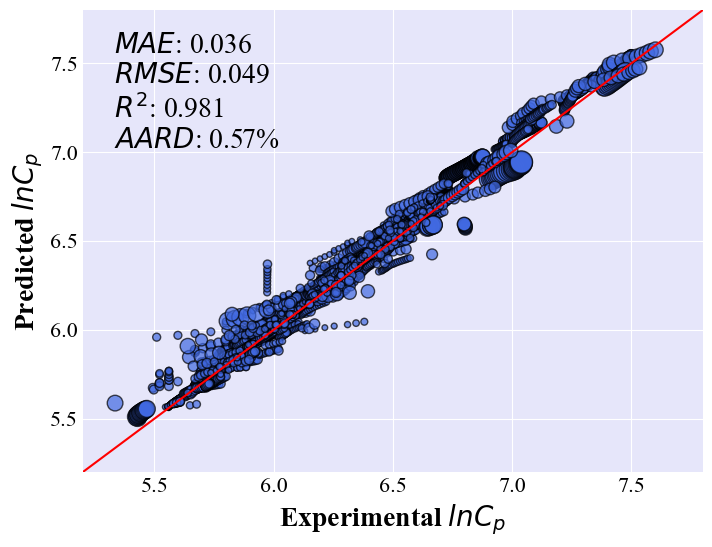

In [9]:

import numpy as np
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(color='white')

# Scatter plot for acidic data
sc = ax.scatter(data[target], pred, c='royalblue', alpha=0.7, s=stds*1000, edgecolors='black')

ax.set_facecolor('lavender')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0,labelsize=16)

# Add title and labels
ax.set_xlabel('Experimental $lnC_p$', fontsize=20, fontweight='bold')
ax.set_ylabel('Predicted $lnC_p$', fontsize=20, fontweight='bold')

ax.text(0.05, 0.95, f"$MAE$: {mae:.3f}\n$RMSE$: {rmse:.3f}\n$R^2$: {r2:.3f}\n$AARD$: {aard*100:.2f}%", fontsize=20, transform=ax.transAxes, verticalalignment='top')
ax.set_axisbelow(True)

ax.plot([5, 8], [5, 8], linestyle='-', color='red')
ax.set_xlim(5.2, 7.8)
ax.set_ylim(5.2, 7.8)
plt.savefig('final/HC.svg', dpi=1200)  

plt.show()


In [19]:
import pandas as pd
from rdkit import Chem
from ILtokenizer import Atomwise_Tokenizer
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from transformers import RobertaForMaskedLM,RobertaConfig


from ILtokenizer import SMILES_Atomwise_Tokenizer
import matplotlib.pyplot as plt
import numpy as np
from ILtokenizer import Atomwise_Tokenizer
import torch
from PIL import Image
from io import BytesIO

def scale(x, min_, max_):
    return (x - min_) / (max_ - min_)

def smi2img(smiles,model_path,tokenizer,device):

    inputs = tokenizer(smiles, return_tensors="pt", max_length=100, truncation=True)
    model = RobertaForMaskedLM(config=RobertaConfig(vocab_size=2000,
                                                    hidden_size=512,
                                                    num_hidden_layers=6,
                                                    num_attention_heads=4,
                                                    intermediate_size=1024,
                                                    hidden_dropout_prob=0.1,
                                                    attention_probs_dropout_prob=0.1,
                                                    output_attentions=False))

    state_dict = torch.load(model_path[1], map_location=device)
    model.load_state_dict(state_dict,strict=False)
    outputs = model(**inputs, output_attentions=True)

    number_of_tokens = inputs.input_ids.size(1)

    the_words = Atomwise_Tokenizer().tokenize(smiles)
    print(the_words)

    the_scores = []
    for i in range(6):
        for ii in range(4):
            the_scores.append( torch.sum(outputs.attentions[i][0][ii], dim=0) / number_of_tokens )

    the_scores = torch.stack(the_scores)
    final_score = torch.sum(the_scores, dim=0) / the_scores.size(0)
    final_score = final_score[1:-1]
    min_,max_ = torch.min(final_score),torch.max(final_score)

    for i in range( final_score.size(0)):
        final_score[i] = scale( final_score[i], min_, max_ )

    print(len(final_score.detach().numpy()),len(the_words))

    fig, ax = plt.subplots(figsize=(len(the_words), 2))
    scatter = ax.scatter(range(len(the_words)), [0] * len(the_words), c=final_score.detach().numpy(), cmap='Reds', s=1000, edgecolors='w')


    for i, word in enumerate(the_words):
        ax.text(i, 0, word, ha='center', va='center', fontsize=15, color='black')

    for i, word in enumerate(the_words):
        ax.text(i, 1, word, ha='center', va='center', fontsize=15, color='black')

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(-0.5, len(the_words) - 0.5)
    ax.set_ylim(-0.5, 1.5)
    ax.set_title('SMILES Colored by Scores')

    plt.colorbar(scatter, ax=ax, orientation='horizontal')
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)

    img = Image.open(buf)
    plt.close(fig)
    return img


def predict_single_smiles(smiles,task,T=None,P=None):

    # 尝试将 SMILES 转换为分子对象
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 'SMILES 不合理!','SMILES 不合理!','SMILES 不合理!'

    else:
        # 标准化 SMILES
        img1 = Draw.MolToImage(mol, size=(500, 500))
        cano_smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)


        length = len(Atomwise_Tokenizer().tokenize(cano_smiles))
        logp= f"{Descriptors.MolLogP(mol):.2f}"
        num_atoms = mol.GetNumAtoms()
        num_rings = Descriptors.RingCount(mol)
        mol_wt = f"{Descriptors.MolWt(mol):.2f}"

        if length > 100:
            length='>100'
        else:
            length=length

        # 创建字典
        basic_property = {
            'SMILES Length': length,
            'LogP': logp,
            'Num Atoms': num_atoms,
            'Num Rings': num_rings,
            'Molecular Weight': mol_wt
        }

        model_paths = [
            f'model_weight/final/{task}/fold_1_best_model.pth',
            f'model_weight/final/{task}/fold_2_best_model.pth',
            f'model_weight/final/{task}/fold_3_best_model.pth',
            f'model_weight/final/{task}/fold_4_best_model.pth',
            f'model_weight/final/{task}/fold_5_best_model.pth',
            f'model_weight/final/{task}/fold_6_best_model.pth',
            f'model_weight/final/{task}/fold_7_best_model.pth',
            f'model_weight/final/{task}/fold_8_best_model.pth',
            f'model_weight/final/{task}/fold_9_best_model.pth',
            f'model_weight/final/{task}/fold_10_best_model.pth'
            ]
        
        if task =='Melting point':
            target='IL'
            means, stds = 363.0857, 75.0207         # tensor(363.0857) tensor(75.0207) torch.Size([26730, 1, 1])

        elif task =='Glass transition temperature':
            target='IL'
            means, stds = 215.6339, 29.5529          # tensor(215.6339) tensor(29.5529) torch.Size([7930, 1, 1])

        elif task =='Thermal decomposition temperature':
            target='IL'
            means, stds = 522.9653, 76.1426         # tensor(522.9653) tensor(76.1426) torch.Size([27790, 1, 1])

        elif task =='IPC-81':
            target='IL'
            means, stds = 3.1156, 1.0641            # tensor(3.1156) tensor(1.0641) torch.Size([3550, 1, 1])


        elif task =='Electrical conductivity':
            target='lnEC'
            means, stds = -1.0393, 1.5858            # tensor(-1.0393) tensor(1.5858) torch.Size([2168, 1, 1])

        elif task =='Thermal conductivity':
            target='TC/W m-1 K-1'
            means, stds = 0.1507, 0.0254            # tensor(0.1507) tensor(0.0254) torch.Size([606, 1, 1])

        elif task =='Density':
            target='d_kg m-3'
            means, stds = 1218.4255, 165.7802        # tensor(1218.4255) tensor(165.7802) torch.Size([39830, 1, 1])


        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        tokenizer = SMILES_Atomwise_Tokenizer('D:/QYX/SmilesPE-master/merged_vocab.txt')
        config = yaml.load(open("config_final.yaml", "r", encoding="utf-8"), Loader=yaml.FullLoader)
        if length=='>100':
            img2=None
        else:
            img2 = smi2img(cano_smiles,model_paths,tokenizer,device)
        outputs = []

        for model_path in model_paths:

            if task == 'Melting point' or task =='Glass transition temperature' or task =='Thermal decomposition temperature' or task =='IPC-81':
                best_model = ILBERT(**config["transformer"]).to(device)
            elif task =='Electrical conductivity':
                best_model = ILBERT_T(**config["transformer"]).to(device)
            elif task =='Thermal conductivity' or task =='Density':
                best_model = ILBERT_T_P(**config["transformer"]).to(device)

            best_model.eval()


            if task =='Electrical conductivity':
                single_sample_df = pd.DataFrame({'Normalized SMILES': [cano_smiles], target: [1], 'T/K': [T] })
            elif task =='Thermal conductivity' or task =='Density':
                single_sample_df = pd.DataFrame({'Normalized SMILES': [cano_smiles], target: [1], 'T/K': [T], 'P/bar': [P] })
            else:   
                single_sample_df = pd.DataFrame({'Normalized SMILES': [cano_smiles], target: [1] })


            test_dataset = SMILES_dataset(df = single_sample_df, tokenizer= tokenizer, target=target)

            best_model.load_state_dict(torch.load(model_path))
            best_model.eval()
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
            test_pred = []
            with torch.no_grad():
                for datas, _ in test_loader:
                    data = [data.to(device) for data in datas]

                    output = best_model(data)
                    output = output * stds + means
                    test_pred.extend(output.detach().cpu().numpy())

            outputs.append(test_pred)

        outputs = np.array(outputs)
        mean_outputs = np.mean(outputs, axis=0).flatten()
        std_outputs = np.std(outputs, axis=0).flatten()
        mean_outputs_rounded = np.round(mean_outputs.item(), 2)
        std_outputs_rounded = np.round(std_outputs.item(), 2)


        if task =='Melting point':
            formatted_result = f"Melting point Tₘ:\n{mean_outputs_rounded} ± {std_outputs_rounded} (K)"

        elif task =='Glass transition temperature':
            formatted_result = f"Glass transition temperature T₍g₎:\n{mean_outputs_rounded} ± {std_outputs_rounded} (K)"

        elif task =='Thermal decomposition temperature':
            formatted_result = f"Thermal decomposition temperature T₍d₎:\n{mean_outputs_rounded} ± {std_outputs_rounded} (K)"

        elif task =='IPC-81':
            formatted_result = f"IPC-81 log₁₀EC₅₀:\n{mean_outputs_rounded} ± {std_outputs_rounded}"

        elif task =='Electrical conductivity':
            formatted_result = f"Electrical conductivity lnκ:\n{mean_outputs_rounded} ± {std_outputs_rounded} ln(S/m)"

        elif task =='Thermal conductivity':
            formatted_result = f"Thermal conductivity λ:\n{mean_outputs_rounded} ± {std_outputs_rounded} (W·m⁻¹·K⁻¹)"

        elif task =='Density':
            formatted_result = f"Density ρ:\n{mean_outputs_rounded} ± {std_outputs_rounded} (kg·m⁻³)"
        return formatted_result,basic_property,img1,img2
    


In [22]:
import pandas as pd
import gradio as gr
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors

# Define Gradio interface with custom layout in the outputs list
iface = gr.Interface(
    fn=predict_single_smiles,
    inputs=[
        gr.Textbox(label="请上传需要预测的IL的smiles"),
        gr.Dropdown(label="请选择任务", choices=["Melting point", "Glass transition temperature", "Thermal decomposition temperature", "IPC-81", "Electrical conductivity", "Thermal conductivity","Density"]),
        gr.Number(label="请输入温度(K)", minimum=100, maximum=800,value=298.15),
        gr.Number(label="请输入压力(bar)", minimum=0.001, maximum=3000,value=1)
    ],


    outputs=[
        gr.Textbox(label="预测的结果"),
        gr.Textbox(label="基础性质"),
        gr.Image(label="分子", type="numpy", width=800, height=800),
        gr.Image(label="权重图", type="numpy", width=800, height=300)

    ],
    title="IL预测工具",
    # description="请上传包括分子smiles的Excel或CSV文件，运行后即可得到预测的酸碱解离常数pKa和相关的基本性质"

)

# Launch the interface
if __name__ == "__main__":
    iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7870
['C', 'C', '[n+]', '1', 'c', 'c', 'n', '(', 'C', ')', 'c', '1', '.', 'N', '#', 'C', '[C-]', '(', 'C', '#', 'N', ')', 'C', '#', 'N']
25 25

Could not create share link. Missing file: c:\Users\ROG\.conda\envs\QYX\Lib\site-packages\gradio\frpc_windows_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_windows_amd64.exe
2. Rename the downloaded file to: frpc_windows_amd64_v0.2
3. Move the file to this location: c:\Users\ROG\.conda\envs\QYX\Lib\site-packages\gradio


['C', 'C', '[n+]', '1', 'c', 'c', 'n', '(', 'C', ')', 'c', '1', '.', 'N', '#', 'C', '[C-]', '(', 'C', '#', 'N', ')', 'C', '#', 'N']
25 25
['C', 'C', '[n+]', '1', 'c', 'c', 'n', '(', 'C', ')', 'c', '1', '.', 'N', '#', 'C', '[C-]', '(', 'C', '#', 'N', ')', 'C', '#', 'N']
25 25


In [16]:
A=['C', 'C', 'C', 'C', '[N+]', '(', 'C', 'C', 'C', 'C', ')', '(', 'C', 'C', 'C', 'C', ')', 'C', 'C', 'C', 'C', '.', 'F', 'C', '(', 'F', ')', '(', 'F', ')', 'c', '1', 'c', 'c', '(', '[B-]', '(', 'c', '2', 'c', 'c', '(', 'C', '(', 'F', ')', '(', 'F', ')', 'F', ')', 'c', 'c', '(', 'C', '(', 'F', ')', '(', 'F', ')', 'F', ')', 'c', '2', ')', '(', 'c', '2', 'c', 'c', '(', 'C', '(', 'F', ')', '(', 'F', ')', 'F', ')', 'c', 'c', '(', 'C', '(', 'F', ')', '(', 'F', ')', 'F', ')', 'c', '2', ')', 'c', '2', 'c', 'c', '(', 'C', '(', 'F', ')', '(', 'F', ')', 'F', ')', 'c', 'c', '(', 'C', '(', 'F', ')', '(', 'F', ')', 'F', ')', 'c', '2', ')', 'c', 'c', '(', 'C', '(', 'F', ')', '(', 'F', ')', 'F', ')', 'c', '1']
print(len(A))

139


In [49]:
predict_single_smiles('CCCC[N+](CCCC)(CCCC)CCCC.FC(F)(F)c1cc([B-](c2cc(C(F)(F)F)cc(C(F','EC',300,100)

('-3.06 ± 0.3',
 {'SMILES Length': '>100',
  'LogP': '16.22',
  'Num Atoms': 74,
  'Num Rings': 4,
  'Molecular Weight': '1105.68'},
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x500>)

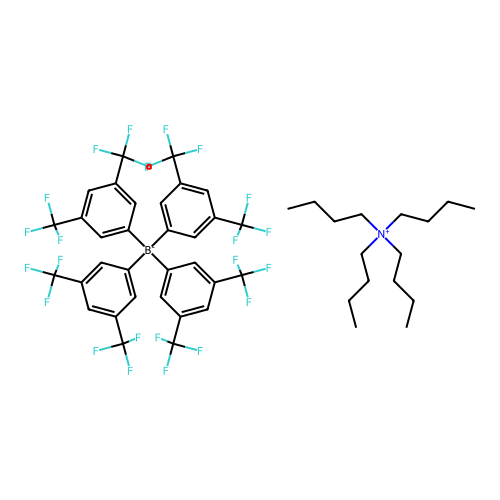

In [47]:
predict_single_smiles('CCCC[N+](CCCC)(CCCC)CCCC.FC(F)(F)c1cc([B-](c2cc(C(F)(F)F)cc(C(F)(F)F)c2)(c2cc(C(F)(F)F)cc(C(F)(F)F)c2)c2cc(C(F)(F)F)cc(C(F)(F)F)c2)cc(C(F)(F)F)c1','EC',300,100)[2]

In [16]:
import pandas as pd
from rdkit import Chem

def randomize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    cano_smiles=Chem.MolToSmiles(mol, isomericSmiles=True,canonical=True)
    if mol is not None:
        new_smiles_list = []
        new_smiles_list.append(cano_smiles)
        for i in range(9):  # 循环9次生成9个随机 SMILES
            new_smiles = Chem.MolToSmiles(mol, doRandom=True)
            new_smiles_list.append(new_smiles)
        return new_smiles_list
    else:
        return [smiles] * 10

def predict_single_smiles_DA(smiles, task):
    config_path = "config_final.yaml"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_paths = [
        f'model_weight/final/{task}/fold_1_best_model.pth',
        f'model_weight/final/{task}/fold_2_best_model.pth',
        f'model_weight/final/{task}/fold_3_best_model.pth',
        f'model_weight/final/{task}/fold_4_best_model.pth',
        f'model_weight/final/{task}/fold_5_best_model.pth',
        f'model_weight/final/{task}/fold_6_best_model.pth',
        f'model_weight/final/{task}/fold_7_best_model.pth',
        f'model_weight/final/{task}/fold_8_best_model.pth',
        f'model_weight/final/{task}/fold_9_best_model.pth',
        f'model_weight/final/{task}/fold_10_best_model.pth'
    ]
    
    if task == 'MP':
        means, stds = 363.0857, 75.0207
    elif task == 'GTT':
        means, stds = 215.6339, 29.5529
    elif task == 'TDT':
        means, stds = 522.9653, 76.1426
    elif task == 'C':
        means, stds = 3.1156, 1.0641

    all_outputs = []

    # 生成 9 个随机 SMILES 和 1 个标准 SMILES
    all_smiles = randomize_smiles(smiles)

    for model_path in model_paths:
        config = yaml.load(open(config_path, "r", encoding="utf-8"), Loader=yaml.FullLoader)
        best_model = ILBERT(**config["transformer"]).to(device)
        best_model.eval()

        model_outputs = []

        for smile in all_smiles:
            single_sample_df = pd.DataFrame({'Normalized SMILES': [smile], 'IL': [1]})
            test_dataset = SMILES_dataset(
                df=single_sample_df,
                tokenizer=SMILES_Atomwise_Tokenizer('D:/QYX/SmilesPE-master/merged_vocab.txt'),
                target='IL'
            )

            best_model.load_state_dict(torch.load(model_path))
            best_model.eval()
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
            test_pred = []
            with torch.no_grad():
                for datas, _ in test_loader:
                    data = [data.to(device) for data in datas]
                    output = best_model(data)
                    output = output * stds + means
                    test_pred.extend(output.detach().cpu().numpy())

            model_outputs.append(test_pred[0])  # 取出预测结果

        all_outputs.append(model_outputs)

    all_outputs = np.array(all_outputs)  # shape: (10, 10)
    print(all_outputs)
    # 计算每个 SMILES 的预测值均值和方差
    mean_outputs = np.mean(all_outputs, axis=0).flatten()
    std_outputs = np.std(all_outputs, axis=0).flatten()
    
    mean_outputs_rounded = np.round(mean_outputs.mean().item(), 2)  # 计算所有预测值的均值
    std_outputs_rounded = np.round(std_outputs.mean().item(), 1)    # 计算所有预测值的方差
    
    # 格式化为字符串
    formatted_result = f"{mean_outputs_rounded} ± {std_outputs_rounded}"
    
    return formatted_result

In [10]:
predict_single_smiles('CCCC[P+](CCCC)(CCCC)CCCC.N#C[N-]C#N','MP')

"发生错误: '>' not supported between instances of 'list' and 'int'"

In [3]:
import numpy as np

def mean_absolute_relative_deviation(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100



import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score,root_mean_squared_error


data_flie = 'data/MP/MP.csv'
target='MP_K'


pKa_data = pd.read_csv(data_flie)
pred_pKa,stds= predict_csv(data_flie,'MP')
actual_pKa_values = pKa_data[target]

# Add predicted pKa and stds to the DataFrame
pKa_data['pred'] = pred_pKa
pKa_data['std'] = stds

# Calculate metrics
actual_pKa_values = pKa_data[target]
mae = mean_absolute_error(actual_pKa_values, pred_pKa)
rmse = root_mean_squared_error(actual_pKa_values, pred_pKa)
r2 = r2_score(actual_pKa_values, pred_pKa)
aard = mean_absolute_relative_deviation(actual_pKa_values, pred_pKa)

# Print metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
print("AARD:", aard)




MAE: 7.053183029066344
RMSE: 9.794893409361745
R2: 0.9829527870791693
AARD: 2.097494300778035


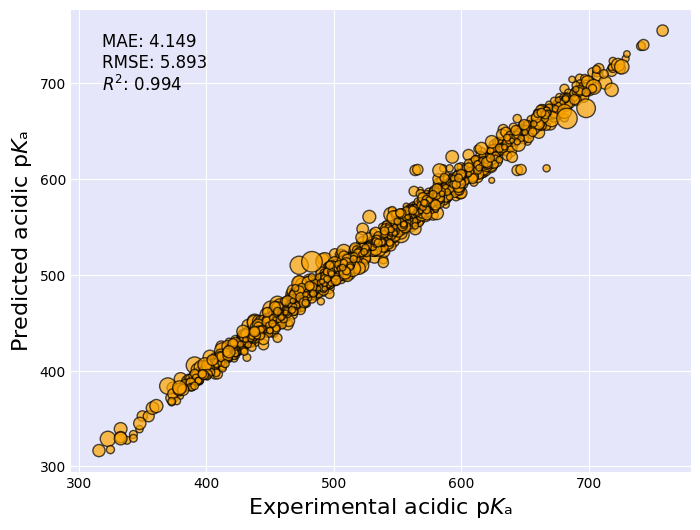

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Plotting
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(color='white')

# Scatter plot for acidic data
sc = ax.scatter(pKa_data['Td/K'], pred_pKa, c='orange', alpha=0.7, s=stds*3, edgecolors='black')

ax.set_facecolor('lavender')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

# Add title and labels
ax.set_xlabel('Experimental acidic p$K$ₐ', fontsize=16)
ax.set_ylabel('Predicted acidic p$K$ₐ', fontsize=16)

ax.text(0.05, 0.95, f"MAE: {mae:.3f}\nRMSE: {rmse:.3f}\n$R^2$: {r2:.3f}", fontsize=12, transform=ax.transAxes, verticalalignment='top')

# ax.set_xlim(1, 13)
# ax.set_ylim(1, 13)
ax.set_axisbelow(True)
# ax.xaxis.set_major_locator(plt.MultipleLocator(2))
# ax.yaxis.set_major_locator(plt.MultipleLocator(2))
# ax.plot([150, 450], [150, 450], linestyle='-', color='red')


plt.show()
